# Day 2 Exercises (NumPy + Matplotlib)

## Part 1: Basic NumPy Operations
a) Generate an array of numbers 0-24. Reshape to a 5x5 matrix.

b) Extract the diagonal of this matrix.

c) Multiply the matrix by an identity matrix of the same shape. Confirm that it is identical to the original.

Hint: Use `np.all` command to confirm all equal. 

d) Join the matrix with itself and return a new matrix with shape (2,5,5).

e) Compute the mean of the concatenated matrix along the first axis. Confirm its equal to the original matrix.

f) Return the indices of the matrix where the elements are greater than 15.

g) Using `np.where`, set all elements of the matrix greater than 15 to 1, else 0.


h) Set all elements of the matrix greater than 15 to 2, less than 5 to 1, else 0.

Hint: `np.where` can be passed as an input to `np.where`.

i) Return the lower triangle of the original matrix.

j) Define a demean function.

k) Apply the demean function across each row of the matrix.

## Part 2: Spike Detection

In the following exercises, you will be manipulating, analyzing, and visualizing preprocessed extracellular electrophysiological data. Specifically, you will be working with a 10s recording taken from a [nerve in the abdomen of a crayfish](https://www.science.smith.edu/departments/neurosci/courses/bio330/labs/L7pix/hookelectr.jpg). Action potentials are visually apparent throughout the entire recording. 

This exercise will focus primarily on the problem of **spike detection**. Before diving in, we recommend you take a few moments to skim [Rey et al. (2015)](https://www.sciencedirect.com/science/article/pii/S0361923015000684), which will help frame the problem and describe the steps involved. Specifically, we recommend reading up to and including Section 2.2, *Spike Detection*.

First, we load the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load data.
npz = np.load('spikes.npz')   # spikes.npz is a compressed NumPy object containing the data.
data = npz['data'] * 1e6      # data is the recording itself, which we convert to microvolts.
times = npz['times']          # times contains the timestamp for each sample of recording.

a) First, check the metadata of *data* and *times*. How many samples (elements) are in *data*? How long (in seconds) is the recording? 

b) Plot the entire raw recording with time (in seconds) on the x-axis and voltage (in microvolts) on the y-axis. 

In this simple circuit, different types of spikes can be identified according to their amplitudes. Do multiple types of spikes appear to be present?

c) Try "zooming in" on different sections of recording. That is, try plotting smaller segments (0.5s, 1.0s) of recordings. How would you restrict your graph to a smaller slice of data? (Hint: this can be done without changing the inputs to `ax.plot`)

d) [Rey et al. (2015)](https://www.sciencedirect.com/science/article/pii/S0361923015000684) suggest a simple spike detection technique via data-driven amplitude thresholding. Specifically, they propose using an amplitude threshold defined as multiple of an estimate of the standard deviation of the noise:

$$ \text{threshold} = k \cdot \hat{\sigma}_n $$

where $k$ is a constant typically between 3-5; and $\hat{\sigma}_n$ is an estimate of the standard deviation of the noise, defined as:

$$ \hat{\sigma}_n = \frac{\text{median} \left( |X| \right)}{0.6745} $$ 

where $|X|$ is the absolute value of the raw data.

Write a function that returns the amplitude threshold as defined above. The function should accept as arguments the raw data, $X$, and the constant, $k$. 

e) Using your function, compute different amplitude thresholds for different values of $k$. Overlay each threshold as a horizonal line on a plot of the raw recording. (Hint: google a horizontal line function in Matplotlib.)

For different threshold levels (values of $k$), how sensitive does the threshold seem to be? In other words, how good is your threshold at detecting "true" spikes from "noise"? (To assess this, it may be helpful to zoom in on specific segments of the data.)

f) Next we need a function that can detect segments of the raw signal that exceed the threshold. This ultimately becomes a clustering problem (i.e. identifying "islands" of signal rising above an "ocean of noise"). 

Though this is definitely doable with core NumPy, the SciPy library has built-in functions specifically written for these purposes. Because these functions are beyond the scope of the bootcamp, we have provided a peak finding function for you. The function relies on the `measurements` tools from scipy.ndimage. For a tutorial, see [here](https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/).

The function, `peak_finder`, accepts a raw data trace and a threshold. It then finds all clusters of samples above the given threshold and returns:
- the indices (positions in the array) corresponding to the peak of each cluster
- the magnitude of the signal at each peak

In [ ]:
def peak_finder(X, thresh):
    """Simple peak finding algorithm.
    
    Parameters
    ----------
    X : array_like, shape (n_times,)
        Raw data trace.
    thresh : float
        Amplitude threshold.
        
    Returns
    -------
    peak_loc : array_like, shape (n_clusters,)
        Index of peak amplitudes.
    peak_mag : array_like, shape (n_clusters,)
        Magnitude of peak amplitudes.
    """
    import numpy as np
    from scipy.ndimage import measurements
    
    ## Error-catching.
    assert X.ndim == 1
    
    ## Identify clusters.
    clusters, ix = measurements.label(X > thresh)
    
    ## Identify index of peak amplitudes. 
    peak_loc = np.concatenate(measurements.maximum_position(X, labels=clusters, index=np.arange(ix)+1))
    
    ## Identify magnitude of peak amplitudes.
    peak_mag = measurements.maximum(X, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag

g) Apply the peak detection algorithm to the raw data using a threshold of your choice (recommendation: $k=6$). How many spikes are detected? If you adjust the threshold up or down, how does this change the number of spikes detected?

h) Now for a challenge. First, plot the first second of the recording. Next, using a scatterplot (or any other method you can think of), plot the peak for each detected spike. In other words, each point in the scatter plot should be (time of spike (s), amplitude of spike (uV)). 

(Hint: *peak_loc* gives you the index of each spike in the data array. Remember that *data* and *times* have the same number of elements.)

i) Remake the plot above using different thresholds. For different threshold levels (values of $k$), how sensitive does the threshold seem to be? In other words, how good is your threshold at detecting "true" spikes from "noise"? (To assess this, it may be helpful to zoom in on different segments of the data.)

j) Based on your exploration above, choose a threshold value. You will use this threshold value for the remainder of this exercise. 

Once you've selected your threshold, use `peak_finder` again to detect spikes in the recording. Then plot a histogram of the spike amplitudes it detects (try bins of 0-150 in increments of 5 uV). 

How many spikes are detected? Based on their amplitudes, how many types of spikes do there appear to be?

k) Based on the plot above, define a set of boundaries that divides the spikes into different clusters. Find a NumPy function that assigns an each spike amplitude to a category based on your defined boundaries. (Hint: there are at least three.) Store the category labels in a new variable, *labels*. 

After binning, how many spikes are in each cluster?

m) **CHALLENGE**: Action potentials last roughly 1-2 milliseconds. With this in mind, extract a 3 ms window around each detected spike; that is, extract 1.5 ms of samples on either side of the detected peak. Store each epoch in a separate list according to its cluster. (Hint: The data were recorded at 10 KHz meaning there are 10 samples per millisecond.)

This is a challenging exercise that can be solved in many different ways. Before jumping in, take a few minutes to brainstorm pseudocode with your team. That is, write out in words each step you need to take to solve this problem.

n) Compute the average spike waveform for each cluster. Then, plot each average waveform in a single plot. Add a legend denoting the spike cluster.

## Bonus: Two-Photon Recordings

In this set of exercises, you will manipulate, analyze, and visualize preprocssed 2-photon calcium imaging data collected from a larval zebrafish. A schematic of the experimental setup is below. The larval zebrafish was fixed in place and presented a series of rotating light-dark bands. The bands moved either in clockwise rotation (red) or counterclockwise rotation (blue). The green box indicates the section of the zebrafish that was imaged.

<img src="larval_zebrafish.png">

Crucially, the larval zebrafish was optogenetically-modified such that its neurons fluoresced (i.e. emitted light) in the presence of calcium. Because neurons are most calcium-rich during an action potential, we can use the luminance (brightness) of the recorded signal as a proxy for neural activity. 

In this exercise, you will try to identify zebrafish neurons that were responsive to clockwise and counterclockwise rotations of the black-and-white stimulus. You will do so using simple but clever analytic techniques. But first, you should get acquainted with the data itself. 

The data in this exercise is a 3d-array with dimensions *(time, x-dim, y-dim)*. That is, the 2-photon microscope measured the fluoresence of a flat sheet (or plane) of neural tissue. The microscope took a new measure of calcium fluoresence 3 times a second (sampling frequency = 3 Hz) for just under 60 seconds. We load in the data below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load data.
npz = np.load('calcium.npz')
data = npz['data']
times = npz['times']

a) Print the shape of the data array. How many measurements are there? How many pixels are there along the x- and y-axes respectively? Remember, the dimensions of the array are *(time, x-dim, y-dim)*.

b) Compute the total luminance. That is, sum across all of the timepoints to compute the total brightness for each pixel. Store this new array in a new variable, `luminance`. 

c) Using `plt.imshow`, plot the total luminance. (Suggestion: use a black and white colormap.)

Neuronal cell bodies should show up as brightish circles surrounding by a dark outline. Can you spot neuronal cell bodies? 

d) There are now many softwares available to perform neuron segmentation, or to identify the spatial boundaries of active neurons in 2-photon data. Because those softwares are beyond the scope of the bootcamp, we will do something much simpler for fun and practice.

Use `np.percentile` and `np.where` to create a luminance mask. That is, use `np.percentile` to identify the brightness value corresponding to a percentile of your choice (e.g. 90%). Use `np.where` to mask all pixels that fall below that level of brightness. Then make a heatmap of the masked data. 

Using different percentiles, how well can you isolate individual neurons?

**[Bonus Challenge]** Can you think of a better approach for defining a luminance mask?

e) Ok, enough fun. Time to get serious.

In the remainder of the exercise, you will try to identify those neurons most responsive to the clockwise (CW) and counterclockwise (CCW) rotation of the stimulus. To do so, we need to take a brief detour to discuss **[matched filters](https://en.wikipedia.org/wiki/Matched_filter)**. The idea is simple but powerful: to identify whether a pattern (e.g. response to CW rotation) is present in some data, correlate the data with a template of the pattern of interest. 

To clarify, let's work through an example. We are interested in identifying whether a sine wave pattern (below, left panel) is present two example timeseries (below, middle/right panels). It should be visually obvious that example 01 (middle panel) is sine wave-like. How can we quantify this? As a first approximation, we can "correlate" the template pattern and example data by multiplying them (see cell below).

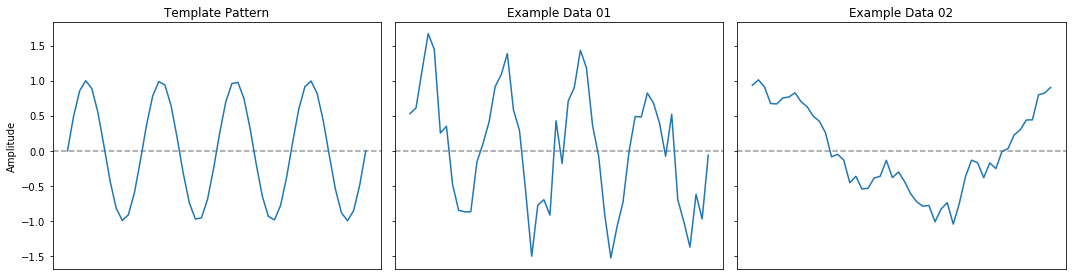

In [3]:
np.random.seed(0)

## Initialize canvas.
fig, axes = plt.subplots(1, 3 , figsize=(15,4), sharex=True, sharey=True)

## Define and plot template.
template = np.sin(np.linspace(0,8,50) * np.pi)
axes[0].plot(template)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.4, zorder=-1)
axes[0].set(xticks=[], ylabel='Amplitude', title='Template Pattern')

## Define and plot example data 01.
ex1 = template + np.random.normal(0,0.3,50)
axes[1].plot(ex1)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.4, zorder=-1)
axes[1].set(xticks=[], title='Example Data 01')

## Define and plot example data 02.
ex2 = np.cumsum(np.random.normal(0,0.2,50))
ex2 -= ex2.mean()
axes[2].plot(ex2)
axes[2].axhline(0, color='k', linestyle='--', alpha=0.4, zorder=-1)
axes[2].set(xticks=[], title='Example Data 02')

plt.tight_layout()

Use `np.dot` to compute the dot product (i.e. sum of the elementwise multiplication of two arrays) between *template* and *ex1*, and *template* and *ex2*. Which do you predict will have the larger value? Why?

In brief, when you correlate (e.g. dot-multiply) a template pattern with some data, the resulting value will be larger if the pattern of interest is present in the data. In fact, this principle is central to signal processing and filtering. We will exploit this fact in the remainder of the exercise.

**Note**: The example above and exercises below are leaving out some important steps regarding normalization, i.e. making sure our measures of correlation are on the same scale. To simplify the problem, we are ignoring this issue but don't mistake this for best practices!

---

f) Below we extract two template patterns, corresponding to the timeseries of clockwise (CW) and counterclockwise (CCW) stimulus rotation, respectively. 

Plot the clockwise (CW) and counterclockwise (CCW) motion timeseries on the same plot with time on the x-axis and rotation on the y-axis. Add a legend to differentiate the two timeseries.

In [4]:
## Extract template patterns.
cw  = npz['cw']
ccw = npz['ccw']

f) Next, exploit the matched filter principle and try to identify neurons responsive to the *clockwise* rotation of the visual stimulus. In other words, take the dot product between *data* and *cw*. (Hint: for `np.dot` to work, time will need to be the last dimension of *data*.) 

Store the resulting matrix in a new variable, *cw_mat* and plot the result.

g) Repeat the step above but now for the counterclockwise stimulus timeseries. Store the resulting matrix in a separate variable, *ccw_mat*. 

Are the same or different neurons prominent in this second plot?

h) Using `np.percentile`, identify the 99th percentile brightest pixels in both *cw_mat* and *ccw_mat*. Use the indexes of these respective sets of pixels to index into *data* and compute the average luminance timeseries within each condition (i.e. CW, CCW).

i) Finally, plot the two separate averaged timeseries. Do they resemble the template patterns from above?